# Defect Detection Using Computer Vision

## Summary

The use case presented in this notebook includes utilizing the DataRobot platform to host a non-DataRobot, pre-trained object detection model to leverage a host of ML Production features such as model monitoring with custom metrics. The included notebook `FasterR-CNN_training.ipynb` details the model training process which generated the model artifacts used here.

This notebook outlines how to:

1. Use the Python client to create/select a custom environment
2. Create a custom model framework for an object detection model
3. Iteratively test and debug a custom model in a custom environment
4. Deploy and run predictions on a custom model
5. Manage custom metrics with a deployment

The below images display a result of the trained object detection model with bounding boxes, class, and confidence values shown.

<p>
<table><tr>
<td> <img src="./display_imgs/scratches_261.jpg" style="width: 250px;"/> </td>
<td> <img src="./display_imgs/scratches_261_scored.png" style="width: 250px;"/> </td>
</tr></table>
</p>

## Setup
This tutorial assumes a few things about your filepath and prior work. 

`custom_model_folder` should contain:
1. The object detection model artifact, e.g. `model_state_dict.pth`
2. `requirements.txt` listing all the dependencies needed to run the model
3. `custom.py` which includes any required function hook edits needed for running the particular model
    - Additional documentation for defining an "unstructured model" and associated function hooks can be found here: [Define Inference Model](https://github.com/datarobot/datarobot-user-models/blob/master/DEFINE-INFERENCE-MODEL.md#unstructured_inference_model)
<!-- 3. The current version of the DataRobot Python Client.
   - Full documentation for the client can be found here: [DataRobot Python Client Docs](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.20.0/index.html) -->

This tutorial also assumes that you have access to app.datarobot.com.
If you use another instance of DataRobot - use appropriate credentials and URL.


### Configuring Models and Environments
For more information on how to properly configure custom models and environments, read the README of our [DataRobot User Models repository](https://github.com/datarobot/datarobot-user-models).

<!-- This tutorial utilizes the `python3_pytorch` environment, which can be found in the [datarobot-user-models](https://github.com/datarobot/datarobot-user-models/tree/master) GitHub repo. -->


### Import libraries

In [50]:
import base64
import getpass
import glob
from io import BytesIO
import json
import os
from pprint import pprint
import sys
import urllib.request
import xml.etree.ElementTree as ET
import zipfile

from PIL import Image, ImageDraw
import datarobot as dr
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
import requests

In [ ]:
# install custom metrics python pkg
!{sys.executable} -m pip install map-boxes

In [5]:
from map_boxes import mean_average_precision_for_boxes

In [ ]:
# download and extract data
urllib.request.urlretrieve(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/NEU-DET/validation_data.zip",
    "./validation_data.zip",
)
with zipfile.ZipFile("./validation_data.zip", "r") as zip_ref:
    zip_ref.extractall("./")

os.listdir("./validation_data/")

['.DS_Store', 'images', 'annotations']

In [88]:
!rm -rf storage/validation_data.zip
!rm -rf storage/__MACOSX

In [6]:
# Path to folder which holds custom.py, model artifact, requirements.txt, etc.
# NOTE: here we use a non-standard extension for our model file (.pth -> .htp) to ensure load_model() in custom.py is used
custom_model_folder = "./assets/"

# Test dataset path
data_path = "./validation_data/"

### Connect to DataRobot

You can read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [7]:
API_KEY = getpass.getpass()  # Get this from the Developer Tools page in the DataRobot UI
endpoint = "https://app.datarobot.com/"  # This should be the URL you use to access the DataRobot UI

dr.client.Client(endpoint="%sapi/v2" % (endpoint), token=API_KEY)
dr.client.get_client()

 ········


## Creating/Selecting a Custom Environment
Custom environment templates for Python 3, Java and R can be found here: [environment templates](https://github.com/datarobot/datarobot-user-models/tree/master/public_dropin_environments)

These can also be selected from the `ExecutionEnvironment` module.

In [8]:
for dr_env in dr.ExecutionEnvironment.list():
    print(dr_env.name, dr_env.id)

[Experimental] Python 3.9 Streamlit 6542cd582a9d3d51bf4ac71e
[DataRobot] Python 3.11 GenAI 64d2ba178dd3f0b1fa2162f0
[DataRobot] Python 3.9 GenAI 64c964448dd3f0c07f47d040
[DataRobot] Python 3.9 Notebook Drop-In with GPU support 64be639d675d8528870a6630
[DataRobot] Python 3.9 ONNX Drop-In 62059a573f7d5f5cebabcba5
Python 3 YOLOv5 test3 61f4484bb73510b7295b3c2d
Python 3 YOLOv5 613906cb384e15533e12496f
[DataRobot] Julia Drop-In 606234e1879feab31ec1abdd
[DataRobot] Legacy Code Environment 6075db569f564155a821b3ab
[DEPRECATED] H2O Drop-In 5f2455d788cef3214ccd8c4a
[DataRobot] Python 3.9 PMML Drop-In 5ee7dfc6433a8423386102ce
[DataRobot] R 4.2.1 Drop-In 5ea850ca1d41c8173c2feef6
[DataRobot] Python 3.9 PyTorch Drop-In 5e8c888007389fe0f466c72b
[DataRobot] Java 11 Drop-In (DR Codegen, H2O) 5e3028d9c38741266ef86452
[DataRobot] Python 3.9 Scikit-Learn Drop-In 5e8c889607389fe0f466c72d
[DataRobot] Python 3.9 XGBoost Drop-In 5e8c88a407389fe0f466c72f
[DataRobot] Python 3.9 Keras Drop-In 5e8c886607389fe0f4

In [9]:
# Select the "Python 3.9 PyTorch Drop-In" env
execution_environment = dr.ExecutionEnvironment.get("5e8c888007389fe0f466c72b")

## Creating a Custom Model
Once the environment is selected, it's time to build the Custom Model. You will need to define details about your custom model in this command depending on the type of model.

### Required fields:
`name` : string that defines the name of the model.

`target_type` : enum that describes the target type. Unstructured (via `datarobot.TARGET_TYPE.UNSTRUCTURED`) allows inputs and outputs that are not verified and beyond the supported project types of DataRobot, therefore allowing the ingest of unbounded images and an output with several dimensions (bounding box coordinates, confidence, class/label).

### Optional Fields:
`description` : a string that describe the model. User can input whatever they want for the description.

`language` : a string that specifies the programming language used in `custom.py`.

In [10]:
# Create the custom model metadata
custom_model = dr.CustomInferenceModel.create(
    name="Faster R-CNN Python 3 PyTorch Custom Model",
    target_type=dr.TARGET_TYPE.UNSTRUCTURED,
    description="This is a Python3-based object detection custom model using a pre-trained Faster R-CNN model.",
    language="python",
)

#### Optionally retrieve an existing custom inference model

In [10]:
custom_model_list = dr.CustomInferenceModel.list(
    # is_deployed=True,  # set to return only deployed models
    order_by="-updated",  # set to define order of returned results
    # search_for='model 1',  # return only models containing 'model 1' in name or description
)
custom_model_list

[CustomInferenceModel('eager-liskov'),
 CustomInferenceModel('Faster R-CNN Python 3 PyTorch Custom Model'),
 CustomInferenceModel('Faster R-CNN Python 3 PyTorch Custom Model'),
 CustomInferenceModel('DR Knowledge Base'),
 CustomInferenceModel('DR Knowledge Base'),
 CustomInferenceModel('DR Knowledge Base'),
 CustomInferenceModel('faster_rcnn'),
 CustomInferenceModel('torch_test'),
 CustomInferenceModel('YOLO Ship Detection (DataFrame style)'),
 CustomInferenceModel('YOLO test 3'),
 CustomInferenceModel('SAS Model 2'),
 CustomInferenceModel('Object Detection'),
 CustomInferenceModel('yolov5_drone-project-drone-retrain-video-frames_train_coco-real'),
 CustomInferenceModel('YOLO Ship Detection')]

In [28]:
custom_model = custom_model_list[2]
custom_model

CustomInferenceModel('Faster R-CNN Python 3 PyTorch Custom Model')

### Create the custom model and kick off environment build

In [11]:
model_version = dr.CustomModelVersion.create_clean(
    custom_model_id=custom_model.id,
    folder_path=custom_model_folder,
    base_environment_id=execution_environment.id,
)

In [12]:
model_version

CustomModelVersion('v1.0')

In [13]:
# view custom model in custom model environment in the gui
print(f"{endpoint}model-registry/custom-models/{custom_model.id}/assemble")

https://app.datarobot.com/model-registry/custom-models/65771c1ce9b1a4da9c3219f6/assemble


## The Model Testing Workflow
The below steps contain an easy way to help ensure that a custom inference model will work in production: You can actually test your custom unstructured model with a specific environment to verify the environment builds before deploying the model.

## Model Testing

### Step 1: Run the Test
To run a custom model test, you upload and save a test dataset from the sample inference data. Then, you simply select the appropriate model and environment (as well as version) IDs, and test it on that dataset.

Once the test is finished, it will have a status property to let you know whether the test passed. If it failed, it will contain an `error` property.

An important note: being an unstructured project type, this test simply checks the environment can build successfully.

In [ ]:
# For non-unstructured custom model types, predictions can be tested via sample inference datasets
# dataset = dr.Dataset.create_from_file(file_path=test_dataset)

In [14]:
# Perform custom model test (~15min, can view progress in the gui)
# This will also build the environment, including the additional dependencies specified
# in requirements.txt in the custom model folder
custom_model_test = dr.CustomModelTest.create(
    custom_model_id=custom_model.id,
    custom_model_version_id=model_version.id,
    # dataset_id=dataset.id,  # for non-unstructured model types
    max_wait=3600,  # 1 hour timeout
)

print("Overall testing status: {}".format(custom_model_test.overall_status))

if any(test["status"] == "failed" for test in custom_model_test.detailed_status.values()):
    print("Test log:\n")
    print(custom_model_test.get_log())

Overall testing status: succeeded


### Step 2: Iterate
It's easy to iterate if the test happened to fail. First, check the error from the custom model test. Then, fix any errors in the code that you uploaded. Finally, upload a new version of the model using the updated code, and test it again.

In [15]:
# Add new version of custom model. Repeat these last two blocks until the model passes testing!
model_version = dr.CustomModelVersion.create_clean(
    custom_model_id=custom_model.id,
    folder_path=custom_model_folder,
    base_environment_id=execution_environment.id,
)
model_version.update(description="Fixing errors from testing (test iteration)")

In [16]:
# Perform custom model test... again
custom_model_test = dr.CustomModelTest.create(
    custom_model_id=custom_model.id,
    custom_model_version_id=model_version.id,
    # dataset_id=dataset.id,
    max_wait=3600,  # 1 hour timeout
)

print("Overall testing status: {}".format(custom_model_test.overall_status))

if any(test["status"] == "failed" for test in custom_model_test.detailed_status.values()):
    print("Test log:\n")
    print(custom_model_test.get_log())

Overall testing status: succeeded


In [17]:
# This command shows all tests that have been run on the model
model_tests = dr.CustomModelTest.list(custom_model_id=custom_model.id)
print(model_tests)

[CustomModelTest('657724aa445396d4da6e7c98'), CustomModelTest('65771c82e80660de696e7ade')]


## Deploying the model
To deploy an inference model, you create something called a `custom_model_image`, which saves the custom model code with a _specific_ environment. This will make it easy to see which custom models have been tested or deployed on specific environments.

Once you have the desired custom model image, simply call the `dr.Deployment.create_from_custom_model_image()` method, inputting the model image's id, the prediction server's `default_prediction_server_id`, and the desired deployment label.

In [18]:
dr.PredictionServer.list()

[PredictionServer(https://mlops.dynamic.orm.datarobot.com),
 PredictionServer(https://datarobot-cfds.dynamic.orm.datarobot.com),
 PredictionServer(https://prod-internal-genai-tests-dont-use.dynamic.orm.datarobot.com),
 PredictionServer(https://cfds-ccm-prod.orm.datarobot.com)]

In [19]:
prediction_server = dr.PredictionServer.list()[0]
prediction_server

PredictionServer(https://mlops.dynamic.orm.datarobot.com)

In [20]:
deployment = dr.Deployment.create_from_custom_model_version(
    model_version.id,
    label="Object detection custom model deployment Faster R-CNN",
    # instance id is only required for Cloud DataRobot App
    # ignore for on-premises Platform installations.
    default_prediction_server_id=prediction_server.id,
    max_wait=3600,  # 1 hour timeout
)

In [21]:
deployment.id

'65772909c73cb89b896ef917'

In [ ]:
# or connect to existing deployment
deployment = dr.Deployment.get("65284d6ed98ce69a5c535911")
deployment

### Making predictions on a deployed custom inference model

We can use the Starter Code available in the DataRobot Deployment (Predictions > Prediction API > Single) for pre-generated Python code that contains functions to interact with the deployement. Primarily, the code contains `make_datarobot_deployment_unstructured_predictions()` and conveniently provides the necessary credentials (API_URL, API_KEY, DATAROBOT_KEY, deployment ID).

In [22]:
API_URL = "{}/predApi/v1.0/deployments/{}/predictionsUnstructured".format(
    prediction_server.url, deployment.id
)
DATAROBOT_KEY = deployment.default_prediction_server["datarobot-key"]

# Don't change this. It is enforced server-side too.
MAX_PREDICTION_FILE_SIZE_BYTES = 52428800  # 50 MB

In [23]:
class DataRobotPredictionError(Exception):
    """Raised if there are issues getting predictions from DataRobot"""


def make_datarobot_deployment_unstructured_predictions(data, deployment_id, mimetype, charset):
    """
    Make unstructured predictions on data provided using DataRobot deployment_id provided.
    See docs for details:
         https://app.datarobot.com/docs/predictions/api/dr-predapi.html

    Parameters
    ----------
    data : bytes
        Bytes data read from provided file.
    deployment_id : str
        The ID of the deployment to make predictions with.
    mimetype : str
        Mimetype describing data being sent.
        If mimetype starts with 'text/' or equal to 'application/json',
        data will be decoded with provided or default(UTF-8) charset
        and passed into the 'score_unstructured' hook implemented in custom.py provided with the model.

        In case of other mimetype values data is treated as binary and passed without decoding.
    charset : str
        Charset should match the contents of the file, if file is text.

    Returns
    -------
    data : bytes
        Arbitrary data returned by unstructured model.


    Raises
    ------
    DataRobotPredictionError if there are issues getting predictions from DataRobot
    """
    # Set HTTP headers. The charset should match the contents of the file.
    headers = {
        "Content-Type": "{};charset={}".format(mimetype, charset),
        "Authorization": "Bearer {}".format(API_KEY),
        "DataRobot-Key": DATAROBOT_KEY,
    }

    url = API_URL.format(deployment_id=deployment_id)

    # Make API request for predictions
    predictions_response = requests.post(
        url,
        data=data,
        headers=headers,
    )
    _raise_dataroboterror_for_status(predictions_response)
    # Return raw response content
    return predictions_response.content


def _raise_dataroboterror_for_status(response):
    """Raise DataRobotPredictionError if the request fails along with the response returned"""
    try:
        response.raise_for_status()
    except requests.exceptions.HTTPError:
        err_msg = "{code} Error: {msg}".format(code=response.status_code, msg=response.text)
        raise DataRobotPredictionError(err_msg)


def make_predictions(data, deployment_id, mimetype, charset):
    """
    Return predictions on `data` using make_datarobot_deployment_unstructured_predictions()
    """
    data_size = sys.getsizeof(data)
    if data_size >= MAX_PREDICTION_FILE_SIZE_BYTES:
        raise ValueError(
            ("Input file is too large: {} bytes. " "Max allowed size is: {} bytes.").format(
                data_size, MAX_PREDICTION_FILE_SIZE_BYTES
            )
        )
    try:
        predictions = make_datarobot_deployment_unstructured_predictions(
            data, deployment_id, mimetype, charset
        )
    except DataRobotPredictionError as exc:
        print(exc)
        raise
    return predictions

#### Additional functions for working with image and object detection data

In [24]:
def get_base_64_image(im):
    # From an image, return base64 encoded PNG image
    with BytesIO() as outfile:
        im.save(outfile, "png")
        image_bytes = outfile.getvalue()
    image_b64 = base64.b64encode(image_bytes).decode("ascii")
    return image_b64

In [25]:
def annotate_image(prediction_image: Image, predictions_df, groundtruth=False, thresh=0.8):
    annotated_image = prediction_image.copy()
    draw = ImageDraw.Draw(annotated_image)
    class_colors = plt.cm.get_cmap("Set1", predictions_df["labels"].max() + 1).colors

    if "scores" not in predictions_df.columns:
        predictions_df["scores"] = 1.0

    for ix, row in predictions_df.pipe(lambda df: df[df.scores >= thresh]).iterrows():
        if groundtruth:
            class_color = 0
            text = "{}".format(row["labels"])
        else:
            class_color = tuple(int(x * 255) for x in class_colors[row["labels"]][:1])
            text = "{} ({:0.3})".format(row["labels"], row["scores"])
        if max(row.xmin, row.ymin, row.xmax, row.ymax) <= 1.0:
            size = prediction_image.size
            row.xmin *= size[1]
            row.ymin *= size[0]
            row.xmax *= size[1]
            row.ymax *= size[0]
        draw.rectangle([(row.xmin, row.ymin), (row.xmax, row.ymax)], outline=class_color, width=3)
        draw.text((row.xmin, row.ymin), text, fill="white")

    return annotated_image

#### Send image to deployment for prediction

In [26]:
test_img_paths = sorted(glob.glob(os.path.join(data_path, "images", "*.jpg")))[:20]
test_img_path = test_img_paths[-1]
test_img_path.split("/")[-1]

'scratches_261.jpg'

##### Test with single image

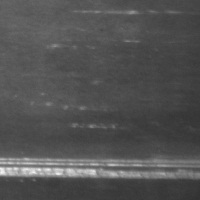

In [27]:
prediction_image = Image.open(test_img_path)
prediction_image

In [28]:
prediction_input = get_base_64_image(prediction_image)
prediction_input[:20]

'iVBORw0KGgoAAAANSUhE'

In [29]:
pred_single_bytes = make_predictions(
    prediction_input, deployment.id, mimetype="application/json", charset="UTF-8"
)
pred_single_bytes

b'{"labels":{"0":1,"1":1,"2":1,"3":1,"4":1,"5":1,"6":1,"7":1,"8":1,"9":1,"10":1,"11":1,"12":1,"13":1,"14":1,"15":1,"16":1,"17":1,"18":1,"19":1,"20":1,"21":1,"22":1,"23":1,"24":1,"25":1,"26":1,"27":1,"28":1,"29":1,"30":1,"31":1,"32":1,"33":1,"34":1,"35":1,"36":1,"37":1,"38":1,"39":1},"scores":{"0":0.8988790512,"1":0.730989933,"2":0.6375282407,"3":0.6011441946,"4":0.467871815,"5":0.4407708645,"6":0.3251947761,"7":0.3114542961,"8":0.3046292067,"9":0.2860198915,"10":0.2737721205,"11":0.245634973,"12":0.224807173,"13":0.2215317786,"14":0.2035304457,"15":0.1871270686,"16":0.1849171668,"17":0.1839261651,"18":0.1786868572,"19":0.1599763781,"20":0.1461728513,"21":0.132313624,"22":0.1308245361,"23":0.1215151623,"24":0.1185274571,"25":0.1146500632,"26":0.1129995063,"27":0.1120025218,"28":0.1110348403,"29":0.1087057069,"30":0.1085053384,"31":0.1039033011,"32":0.0926248953,"33":0.084703438,"34":0.0832260251,"35":0.0807019323,"36":0.0770947412,"37":0.060823366,"38":0.0588032007,"39":0.0560027063},"x

In [30]:
pred_single_df = pd.DataFrame(json.loads(pred_single_bytes))
pred_single_df

,labels,scores,xmin,ymin,xmax,ymax
0,1,0.898879,0.000000,155.107971,196.049286,185.652802
1,1,0.730990,65.906494,4.150574,185.256256,17.335661
2,1,0.637528,63.250824,100.448692,120.299164,132.620010
3,1,0.601144,0.000000,134.913483,200.000000,179.032379
4,1,0.467872,68.585243,2.424901,198.483856,28.478519
5,1,0.440771,71.516418,9.657757,185.824341,22.217731
6,1,0.325195,0.000000,112.160194,139.694550,195.358002
7,1,0.311454,35.854866,151.441193,200.000000,174.968872
8,1,0.304629,67.008011,7.247781,152.276367,20.015083
9,1,0.286020,58.253574,114.264030,127.043091,132.053604


In [31]:
# predict on batch
preds_df = pd.DataFrame()
for test_img_p in test_img_paths:
    pred_img_b64 = get_base_64_image(Image.open(test_img_p))
    pred_bytes = make_predictions(
        pred_img_b64, deployment.id, mimetype="application/json", charset="UTF-8"
    )
    df_ = pd.DataFrame(json.loads(pred_bytes))
    df_["filename"] = test_img_p.split("/")[-1]
    df_["timestamp"] = pd.to_datetime("today")

    preds_df = pd.concat([preds_df, df_], axis=0, ignore_index=True)

preds_df

,labels,scores,xmin,ymin,xmax,ymax,filename,timestamp
0,1,0.881277,0.000000,104.507248,159.336609,133.358154,scratches_241.jpg,2023-12-11 10:38:57.023346
1,1,0.814754,6.901443,24.614864,200.000000,47.612072,scratches_241.jpg,2023-12-11 10:38:57.023346
2,1,0.662734,120.827332,174.528442,191.507202,193.147614,scratches_241.jpg,2023-12-11 10:38:57.023346
3,1,0.599043,80.770538,164.872620,196.405060,194.066833,scratches_241.jpg,2023-12-11 10:38:57.023346
4,1,0.591915,128.783890,164.855438,181.432785,195.831787,scratches_241.jpg,2023-12-11 10:38:57.023346
...,...,...,...,...,...,...,...,...
551,1,0.080702,121.584427,10.561089,196.337204,23.401585,scratches_261.jpg,2023-12-11 10:40:01.735730
552,1,0.077095,110.270660,3.324675,191.354645,46.965096,scratches_261.jpg,2023-12-11 10:40:01.735730
553,1,0.060823,52.024719,107.675537,123.658829,192.824921,scratches_261.jpg,2023-12-11 10:40:01.735730
554,1,0.058803,86.903595,152.141266,194.166046,168.290436,scratches_261.jpg,2023-12-11 10:40:01.735730


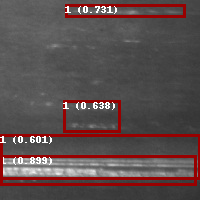

In [32]:
# view prediction
prediction_image_annotated = annotate_image(
    prediction_image,
    preds_df[preds_df.filename == test_img_path.split("/")[-1]],
    thresh=0.6,
)
prediction_image_annotated

## Custom metrics

### Creating custom metric with GUI

Navigate to the custom metrics tab of the deployment in the gui and utilize the [custom metrics docs page](https://app.datarobot.com/docs/mlops/monitor/custom-metrics.html#add-custom-metrics) to set up custom metrics. For this object detection workflow we created a metric for mean average precision (mAP).

- Name: mAP
- Name of y-axis (label): mAP
- Aggregation type: Gauge
- Metric direction: Higher is better
- timestamp column: timestamp
- Value Column: mAP
- Date format: %Y-%m-%d %H:%M:%S 2077-01-31 12:57:25

Note: When presented with the Upload Data dialog box, select the "Use API" option to generate the Python code used here (with the `if __name__ == "__main__":` block removed).

The image below shows a sample mAP custom metric view after processing two batches of images.
<table><tr>
<td> <img src="display_imgs/mAP_sample.png"/> </td>
</tr></table>

In [33]:
# get the url for the custom metrics section of the deployment
deployment_url = deployment.get_uri()
print(deployment_url.replace("overview", "custom-metrics"))

https://app.datarobot.com/deployments/65772909c73cb89b896ef917/custom-metrics


In [66]:
"""
Usage:
    python datarobot-custom-metric-upload.py <input-file.csv>
    CSV should contain timestamp and value columns

This example uses the requests and pandas library which you can install with:
    pip install requests
    pip install pandas
We highly recommend that you update SSL certificates with:
    pip install -U "urllib3[secure]" certifi
"""
from __future__ import absolute_import

import sys

import pandas as pd
import requests

API_URL = "https://app.datarobot.com/api/v2/deployments/{}/customMetrics/{}/fromJSON/"
DEPLOYMENT_ID = "65772909c73cb89b896ef917"
CUSTOM_METRIC_ID = "65774ede3760421973d89174"
MODEL_PACKAGE_ID = None

HEADERS = {
    "Authorization": "Bearer {}".format(API_KEY),
    "User-Agent": "IntegrationSnippet-Requests",
}


def submit_data(df):
    rows = [
        {"timestamp": ts.isoformat(), "value": value}
        for ts, value in zip(df["timestamp"], df["value"])
    ]
    response = requests.post(
        API_URL.format(DEPLOYMENT_ID, CUSTOM_METRIC_ID),
        json={
            "modelPackageId": MODEL_PACKAGE_ID,
            "buckets": rows,
        },
        headers=HEADERS,
    )
    response.raise_for_status()

In [67]:
# support funciton to pull ai catalog data into pandas df


def ai_catalog_to_pandas(dataset):
    with BytesIO() as outfile:
        dataset.get_file(filelike=outfile)
        outfile.seek(0)
        df = pd.read_csv(outfile)
    return df

#### Read all groundtruth

In [37]:
# custom function to pull labels into required format


def get_gt_from_dir(img_dir):
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    result_dict = {
        "xmin": [],
        "ymin": [],
        "ymax": [],
        "xmax": [],
        "filename": [],
        "labels": [],
        "label_idx": [],
    }
    for img_path in img_paths:
        label_idx = 0
        img_trg_path = img_path.replace("images", "annotations").replace(".jpg", ".xml")
        with open(img_trg_path, "r") as file:
            xml_data = file.read()
            root = ET.fromstring(xml_data)
            for obj in root.findall("object"):
                xmin = float(obj.find("bndbox/xmin").text)
                ymin = float(obj.find("bndbox/ymin").text)
                xmax = float(obj.find("bndbox/xmax").text)
                ymax = float(obj.find("bndbox/ymax").text)
                # would also grab class here for a multiclass object detector
                result_dict["xmin"].append(xmin)
                result_dict["ymin"].append(ymin)
                result_dict["xmax"].append(xmax)
                result_dict["ymax"].append(ymax)
                result_dict["filename"].append(img_path.split("/")[-1])
                result_dict["labels"].append(1)
                result_dict["label_idx"].append(label_idx)
                label_idx += 1

    return pd.DataFrame.from_dict(result_dict)

In [44]:
gt_df = get_gt_from_dir(os.path.join(data_path, "images"))
gt_df

,xmin,ymin,ymax,xmax,filename,labels,label_idx
0,1.0,25.0,50.0,199.0,scratches_241.jpg,1,0
1,1.0,106.0,136.0,161.0,scratches_241.jpg,1,1
2,7.0,35.0,52.0,108.0,scratches_242.jpg,1,0
3,82.0,156.0,171.0,199.0,scratches_242.jpg,1,1
4,2.0,169.0,195.0,27.0,scratches_242.jpg,1,2
...,...,...,...,...,...,...,...
118,13.0,121.0,135.0,99.0,scratches_297.jpg,1,1
119,6.0,7.0,44.0,199.0,scratches_298.jpg,1,0
120,2.0,135.0,186.0,200.0,scratches_299.jpg,1,0
121,88.0,1.0,34.0,200.0,scratches_300.jpg,1,0


#### Upload ground truth dataframe to the AI Catalog

In [47]:
# Join with existing ground truth dataframe if one exists

GT_AI_CATALOG_ID = "657333649081a0db62ef8558"
dataset = dr.Dataset.get(GT_AI_CATALOG_ID)

gt_existing_df = ai_catalog_to_pandas(dataset)

# pull unique filenames from each dataset
gt_existing_fns = gt_existing_df.filename.unique()
gt_fns = gt_df.filename.unique()

existing_dupe_fns = [fn for fn in gt_existing_fns if fn in gt_fns]

# drop outdated ground truth labels
gt_existing_df = gt_existing_df[~gt_existing_df["filename"].isin(existing_dupe_fns)]

gt_df = pd.concat([gt_existing_df, gt_df], axis=0)
print(gt_df.shape)

# update AI Catalog
gt_dataset = dr.Dataset.create_version_from_in_memory_data(
    dataset_id=GT_AI_CATALOG_ID, data_frame=gt_df
)

(123, 7)


In [48]:
# view dataset in the ai catalog
gt_dataset.get_uri()

'https://app.datarobot.com/ai-catalog/657333649081a0db62ef8558'

In [ ]:
# if new ai catalog entry

gt_dataset = dr.Dataset.create_from_in_memory_data(data_frame=gt_df)
gt_dataset.modify(name="Object Detection Ground Truth Table")

gt_dataset.get_uri()

#### Test custom metric data submission

In [60]:
df = pd.DataFrame(
    {
        "timestamp": [
            pd.to_datetime("today") - DateOffset(days=1),
            pd.to_datetime("today"),
        ],
        "value": [0.65, 0.71],
    }
)
df

,timestamp,value
0,2023-12-10 13:17:09.085422,0.65
1,2023-12-11 13:17:09.085766,0.71


In [61]:
submit_data(df)

### Compute metrics

In [54]:
# get groundtruth for predictions
gt_fns = gt_df.filename.unique()
pred_fns = preds_df.filename.unique()

fns = [fn for fn in gt_fns if fn in pred_fns]

gt_subset_df = gt_df[gt_df.filename.isin(fns)]
gt_subset_df.head()

,xmin,ymin,ymax,xmax,filename,labels,label_idx
0,1.0,25.0,50.0,199.0,scratches_241.jpg,1,0
1,1.0,106.0,136.0,161.0,scratches_241.jpg,1,1
2,7.0,35.0,52.0,108.0,scratches_242.jpg,1,0
3,82.0,156.0,171.0,199.0,scratches_242.jpg,1,1
4,2.0,169.0,195.0,27.0,scratches_242.jpg,1,2


In [55]:
# metric computing package expects normalized box coordinates
# this function and the operation below assumes square images

img_size = prediction_image.size


def norm(row):
    return row / img_size[0]

In [56]:
# reduce predictions to those above thresh and normalize coordinates


CONF_THRESH = 0.5

preds_norm_df = preds_df.copy()
print("Raw predictions:", len(preds_norm_df))
preds_norm_df = preds_norm_df[preds_norm_df.scores > CONF_THRESH].reset_index(drop=True)
# preds_norm_df = preds_norm_df[preds_norm_df.filename.isin(fns)]  # if testing with a subset
print(f"Predictions after thresholding with {CONF_THRESH}: {len(preds_norm_df)}")
preds_norm_df.xmin = preds_norm_df.xmin.apply(norm)
preds_norm_df.ymin = preds_norm_df.ymin.apply(norm)
preds_norm_df.xmax = preds_norm_df.xmax.apply(norm)
preds_norm_df.ymax = preds_norm_df.ymax.apply(norm)

gt_norm_df = gt_subset_df.copy()
gt_norm_df.xmin = gt_norm_df.xmin.apply(norm)
gt_norm_df.ymin = gt_norm_df.ymin.apply(norm)
gt_norm_df.xmax = gt_norm_df.xmax.apply(norm)
gt_norm_df.ymax = gt_norm_df.ymax.apply(norm)

Raw predictions: 556
Predictions after thresholding with 0.5: 64


In [57]:
# compute metrics
ann = gt_norm_df[["filename", "labels", "xmin", "xmax", "ymin", "ymax"]].values
det = preds_norm_df[["filename", "labels", "scores", "xmin", "xmax", "ymin", "ymax"]].values
mean_ap, average_precisions = mean_average_precision_for_boxes(ann, det, iou_threshold=0.5)

Number of files in annotations: 20
Number of files in predictions: 20
Unique classes: 1
Detections length: 20
Annotations length: 20
1                              | 0.823475 |      38
mAP: 0.823475


In [62]:
# add metrics to prediction dataframe
preds_norm_df["mAP"] = mean_ap
preds_norm_df["ave_prec"] = 0.0
for k, v in average_precisions.items():
    preds_norm_df.loc[preds_norm_df["labels"] == int(k), "ave_prec"] = v[0]

preds_norm_df

,labels,scores,xmin,ymin,xmax,ymax,filename,timestamp,mAP,ave_prec
0,1,0.881277,0.000000,0.522536,0.796683,0.666791,scratches_241.jpg,2023-12-11 10:38:57.023346,0.823475,0.823475
1,1,0.814754,0.034507,0.123074,1.000000,0.238060,scratches_241.jpg,2023-12-11 10:38:57.023346,0.823475,0.823475
2,1,0.662734,0.604137,0.872642,0.957536,0.965738,scratches_241.jpg,2023-12-11 10:38:57.023346,0.823475,0.823475
3,1,0.599043,0.403853,0.824363,0.982025,0.970334,scratches_241.jpg,2023-12-11 10:38:57.023346,0.823475,0.823475
4,1,0.591915,0.643919,0.824277,0.907164,0.979159,scratches_241.jpg,2023-12-11 10:38:57.023346,0.823475,0.823475
...,...,...,...,...,...,...,...,...,...,...
59,1,0.543772,0.514475,0.352245,1.000000,0.470509,scratches_260.jpg,2023-12-11 10:39:57.733130,0.823475,0.823475
60,1,0.898879,0.000000,0.775540,0.980246,0.928264,scratches_261.jpg,2023-12-11 10:40:01.735730,0.823475,0.823475
61,1,0.730990,0.329532,0.020753,0.926281,0.086678,scratches_261.jpg,2023-12-11 10:40:01.735730,0.823475,0.823475
62,1,0.637528,0.316254,0.502243,0.601496,0.663100,scratches_261.jpg,2023-12-11 10:40:01.735730,0.823475,0.823475


### View predictions

In [63]:
test_img_fn = gt_norm_df.filename.unique()[4]
test_img_fn

'scratches_245.jpg'

In [64]:
prediction_image = Image.open(test_img_path.replace(test_img_path.split("/")[-1], test_img_fn))

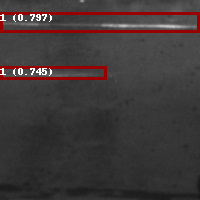

In [68]:
pred_img = annotate_image(
    prediction_image,
    preds_norm_df[preds_norm_df.filename == test_img_fn],
    thresh=CONF_THRESH,
)
pred_img

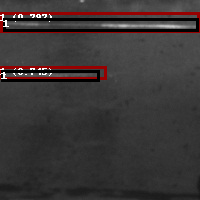

In [73]:
# add groundtruth boxes to pred_img
annotate_image(
    pred_img,
    gt_norm_df[gt_norm_df.filename == test_img_fn],
    groundtruth=True,
    thresh=CONF_THRESH,
)

### Upload custom metrics to the DataRobot deployment

In [74]:
mean_ts = pd.DataFrame(preds_norm_df.timestamp.unique(), columns=["timestamp"]).timestamp.mean()
df_map = pd.DataFrame({"timestamp": [mean_ts], "value": [mean_ap]})
df_map

,timestamp,value
0,2023-12-11 10:39:28.812912896,0.823475


In [75]:
submit_data(df_map)

In [77]:
# view in gui
print(deployment_url.replace("overview", "custom-metrics"))

https://app.datarobot.com/deployments/65772909c73cb89b896ef917/custom-metrics


#### Upload prediction dataframe to the AI Catalog

In [79]:
# Join with existing prediction df if needed

PRED_AI_CATALOG_ID = "65733a719081a0db62ef85d3"
dataset = dr.Dataset.get(PRED_AI_CATALOG_ID)

pred_existing_df = ai_catalog_to_pandas(dataset)

pred_df = pd.concat([pred_existing_df, preds_norm_df], axis=0)

# update AI Catalog
pred_dataset = dr.Dataset.create_version_from_in_memory_data(
    dataset_id=PRED_AI_CATALOG_ID, data_frame=pred_df
)
pred_dataset.get_uri()

'https://app.datarobot.com/ai-catalog/65733a719081a0db62ef85d3'

In [92]:
# if new ai catalog entry
# pred_dataset = dr.Dataset.create_from_in_memory_data(data_frame=pred_df)
# pred_dataset.modify(name='Object Detection Prediction Table')

pred_dataset.get_uri()

'65733a719081a0db62ef85d3'

### Altering model architecture / problem spaces

This notebook assumes the use of a Faster R-CNN model and its associated input/output schema. To alter the workflow for alternative architectures, changes to the following may be needed:
- do_faster_rcnn_scoring() in custom.py
- annotate_image()
- get_gt_from_dir()
- norm()